In [134]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim

# General approach

The goal is to find a maximum-weight bipartite matching where the cost function is unknown and depends on features of the inputs. Additionally, we might want a matching that trades off optimality and diversity by way of entropy regularization -- conveniently, this is what Sinkhorn does.

We have elements from the two sides $i, j$ with features $u_i, v_j$, the true cost is some $C^*_{ij}$, and we want to learn our own $C_{ij} = f(u_i, v_j; \theta)$. In one interesting case many of the $C^*_{ij}$ may be 0, meaning these edges do not exist and should not be matched.

Two approaches can be taken:

1. Two-stage approach

The two-stage approach is simple. One simply learns $f$ to predict the true observed $C^*_{ij}$ as well as possible, and then make matches based on the predictions of $f$. This approach should work well if $f$ can successfully learn the correct matching based on the features. There are some experimental details here -- which information exactly does $f$ get to observe -- do we get to see pairs of unmatched nodes, or only the actual matches made? $f$ here can be any learner.

2. Predict-and-optimize approach

The idea here is to still have $f$ output cost functions, but then pass these into a differentiable surrogate for the matching (Sinkhorn), and maximize the total weight of the observed matching. We expect this approach to win if $f$ cannot make perfect predictions. $f$ here must be a gradient based approach, i.e. a (shallow) NN.

# Some notes

One advantage of this compared to the Wilder et al paper is that for a problem this simple, Sinkhorn is much nicer to deal with than their Gurobi nightmare or even qpth, and can stay on the GPU.

## first steps

Consider the case where we either have edges or don't, and want to predict that from features only, in order to choose a maximum-weight matching.

In [135]:
dim = 10
N = 100
u_feats = torch.rand(N, dim)
v_feats = torch.rand(N, dim)

In [136]:
scores_mat = u_feats @ (v_feats.t())

In [137]:
edge_mat = (scores_mat > 2.5).float()

### training, batching, etc.

first just train on dataset to get architecture up

In [138]:
model = nn.Sequential(*[nn.Linear(dim*2, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)])
model.train()

Sequential(
  (0): Linear(in_features=20, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [139]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [140]:
def data_format(u, v, edges):
    for i in range(u.shape[0]):
        for j in range(v.shape[0]):
            yield torch.cat((u[i,:], v[j,:])), edges[i, j]

In [141]:
results = list(data_format(u_feats, v_feats, edge_mat))
vecs = torch.stack([x[0] for x in results])
edges = torch.stack([x[1] for x in results]).view(-1,1)

In [142]:
def trainbatch(model, criterion, optimizer, vecs, edges, device='cuda'):
    model.train()
    vecs.to(device)
    edges.to(device)
    model.zero_grad()
    out = model(vecs)
    loss = criterion(out, edges)
    save_loss = loss.item()
    loss.backward()
    optimizer.step()
    return loss.item()
    

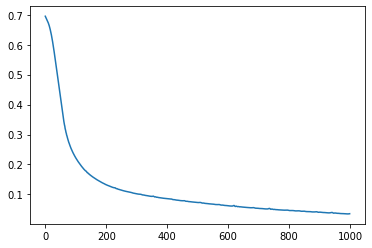

In [143]:
losses = []
for i in range(1000):
    loss = trainbatch(model, criterion, optimizer, vecs, edges)
    losses.append(loss)
plt.plot(losses)

## optimization problem

given our trained model, we want the scaffolding to go from a bunch of features to a bipartite matching solution

In [144]:
def predicted_edges_to_matrix(edges):
    dim = int(np.sqrt(edges.shape[0]))
    return edges.view(dim, dim)

In [145]:
edge_mat

tensor([[1., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.]])

In [146]:
torch.all(predicted_edges_to_matrix(edges) == edge_mat)

tensor(True)

## bipartite matching

given a cost (edge is special case) matrix, find the maximum weight bipartite matching at test time, optionally with an entropy penalty. Let's do this with Gurobi. Note Gurobi can't handle entropy in the objective!

In [164]:
import gurobipy as gp

def opt_match(cost_matrix):
    # this will have to be modified to handle multiple similar items (integer not binary)
    model = gp.Model()
    x = {}
    l_n = cost_matrix.shape[0]
    r_n = cost_matrix.shape[1]
    for i in range(l_n):
        for j in range(r_n):
            x[i, j] = model.addVar(vtype=gp.GRB.BINARY, name=f'x_{i}_{j}')
    model.update()
    match_once_constraints = []
    for i in range(l_n):
        match_once_constraints.append(
            model.addConstr(gp.quicksum(x[i, j] for j in range(r_n)) <= 1))
    for j in range(r_n):
        match_once_constraints.append(
            model.addConstr(gp.quicksum(x[i, j] for i in range(l_n)) <= 1))
    obj = gp.QuadExpr()
    for i in range(l_n):
        for j in range(r_n):
            obj += x[i,j] * cost_matrix[i,j].item()
    model.setObjective(obj, gp.GRB.MAXIMIZE)
    model.optimize()
    model.update()
    
    result = torch.zeros_like(cost_matrix)
    for i in range(l_n):
        for j in range(r_n):
            result[i, j] = x[i,j].x
    return result
    

In [165]:
result = opt_match(edge_mat)

Optimize a model with 200 rows, 10000 columns and 20000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 92.0000000
Presolve removed 10 rows and 5321 columns
Presolve time: 0.02s
Presolved: 190 rows, 4679 columns, 9358 nonzeros
Variable types: 0 continuous, 4679 integer (4679 binary)

Root relaxation: objective 9.300000e+01, 445 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      93.0000000   93.00000  0.00%     -    0s

Explored 0 nodes (445 simplex iterations) in 0.03 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 93 92 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.30000000

In [166]:
score = torch.sum(result * edge_mat)

random model should make wrong predictions leading to poor performance

In [170]:
model = nn.Sequential(*[nn.Linear(dim*2, 128), nn.ReLU(), nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)])
model.eval()

Sequential(
  (0): Linear(in_features=20, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=1, bias=True)
)

In [194]:
predicted_edges = (f.sigmoid(model(vecs)) > .5).float().detach()

In [196]:
predicted_result = opt_match(predicted_edges_to_matrix(predicted_edges))

Optimize a model with 200 rows, 10000 columns and 20000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 99.0000000
Presolve removed 0 rows and 746 columns
Presolve time: 0.01s
Presolved: 200 rows, 9254 columns, 18508 nonzeros
Variable types: 0 continuous, 9254 integer (9254 binary)

Root relaxation: objective 1.000000e+02, 316 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     100.0000000  100.00000  0.00%     -    0s

Explored 0 nodes (316 simplex iterations) in 0.04 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 100 99 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.00000000

In [197]:
torch.sum(predicted_result * edge_mat)

tensor(42.)

after training performance should improve

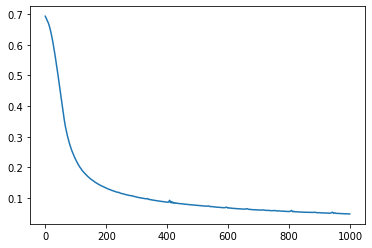

In [199]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
losses = []
for i in range(1000):
    loss = trainbatch(model, criterion, optimizer, vecs, edges)
    losses.append(loss)
plt.plot(losses)

In [200]:
trained_edges = (f.sigmoid(model(vecs)) > .5).float().detach()
trained_result = opt_match(predicted_edges_to_matrix(trained_edges))
torch.sum(trained_result * edge_mat)

Optimize a model with 200 rows, 10000 columns and 20000 nonzeros
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 92.0000000
Presolve removed 13 rows and 5502 columns
Presolve time: 0.03s
Presolved: 187 rows, 4498 columns, 8996 nonzeros
Variable types: 0 continuous, 4498 integer (4498 binary)

Root relaxation: objective 9.300000e+01, 455 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      93.0000000   93.00000  0.00%     -    0s

Explored 0 nodes (455 simplex iterations) in 0.06 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 93 92 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.30000000

tensor(87.)

## sinkhorn

need to implement sinkhorn, as a function of input cost matrix and (at the moment) uniform marginals

In [334]:
def sinkhorn_plan(weight_mat, eps=1e-1, rounds=5):
    K = torch.exp(-weight_mat / eps)
    l_n = weight_mat.shape[0]
    r_n = weight_mat.shape[1]
    a = torch.ones(l_n) / l_n
    b = torch.ones(r_n) / r_n
    g = torch.ones(l_n)
    f = eps * (torch.log(a) - torch.log(K @ torch.exp(g / eps)))
    g = eps * (torch.log(b) - torch.log(K.t() @ torch.exp(f / eps)))
    for i in range(rounds):
        f = eps * (torch.log(a) - torch.log(K @ torch.exp(g / eps)))
        g = eps * (torch.log(b) - torch.log(K.t() @ torch.exp(f / eps)))
    return torch.diag(torch.exp(f / eps)) @ K @ torch.diag(torch.exp(g / eps))
    

In [335]:
def sinkhorn_plan(weight_mat, eps=1e-2, rounds=5):
    K = torch.exp(-weight_mat / eps)
    l_n = weight_mat.shape[0]
    r_n = weight_mat.shape[1]
    a = torch.ones(l_n) / l_n
    b = torch.ones(r_n) / r_n
    v = torch.ones(l_n)
    u = a / (K @ v)
    v = b / (K.t() @ u)

    for i in range(rounds):
        u = a / (K @ v)
        v = b / (K.t() @ u)

    return torch.diag(u) @ K @ torch.diag(v)
    

In [350]:
pl=sinkhorn_plan(-edge_mat*0.1, eps=5e-3, rounds=100)

In [351]:
torch.sum(pl, axis=1)

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100])

In [352]:
torch.ones(5)/5

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [370]:
sinkhorn_hardmax = (f.one_hot(torch.max(pl, axis=0).indices, 100).float())

In [371]:
(sinkhorn_hardmax * edge_mat).sum()

tensor(46.)

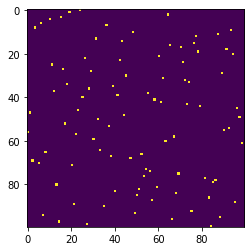

In [362]:
plt.imshow(trained_result)

### future notes

eventually we will need a case (for entropic matching) where many of the inputs are indistinguishable -- maybe just discrete and/or binary input features.

should try hiding some of the true features

eventually will need a more interesting function to predict edges